In [9]:
import numpy as np
import torch
from modules.model.model import InstanceSegmentation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import cv2

In [2]:
# Initialize
model = InstanceSegmentation()

# Dummy Input
dummy_img = torch.rand(2, 3, 600, 600) # Batch size 2

# Dummy Targets (needed for training mode)
dummy_targets = [
    {
        'boxes': torch.tensor([[50, 50, 100, 100]], dtype=torch.float32),
        'labels': torch.tensor([1], dtype=torch.int64),
        'masks': torch.randint(0, 2, (1, 600, 600), dtype=torch.uint8)
    },
    {
        'boxes': torch.tensor([[150, 150, 200, 200]], dtype=torch.float32),
        'labels': torch.tensor([1], dtype=torch.int64),
        'masks': torch.randint(0, 2, (1, 600, 600), dtype=torch.uint8)
    }
]

# Test Forward Pass (Training)
model.train()
loss = model(dummy_img, dummy_targets)
print(f"Training Loss: {loss.item()}")

# Test Forward Pass (Inference)
model.eval()
with torch.no_grad():
    output = model(dummy_img)
    print("Inference Output Boxes:", output[0]['boxes'])
    print("Inference Output Masks Shape:", output[0]['masks'].shape)

Training Loss: 1.61439847946167
Inference Output Boxes: tensor([[  0.0000, 142.9298, 303.7200, 588.9137],
        [  0.0000, 214.6343,  74.5611, 580.5297],
        [  0.0000, 299.1985, 446.5600, 590.8903],
        [  1.0124, 210.2529,  59.0734, 259.5811],
        [  0.0000, 291.4117,  42.4027, 589.8005],
        [  0.0000, 413.0411,  59.2600, 577.0284],
        [  5.5315, 189.0215, 144.7917, 582.3181],
        [  7.4575, 355.4404,  64.0000, 404.2001],
        [  6.2989, 248.0051,  64.7074, 295.0347],
        [  0.0000, 376.3354, 132.2270, 588.3266],
        [512.0982, 130.8043, 519.7551, 139.0611],
        [  0.0000, 190.6530, 583.9385, 526.4236],
        [  0.0000, 534.3928, 125.6692, 595.9495],
        [ 17.9544, 324.9464, 198.7198, 591.1420],
        [  0.0000, 460.8616, 248.0742, 596.1439],
        [500.2363, 122.8718, 507.7843, 129.5756],
        [537.1041, 444.0873, 600.0000, 591.1581],
        [ 25.9950, 210.1587,  44.1686, 219.1307],
        [480.3816, 133.4548, 487.8515, 141.7

In [3]:
def visualize_prediction(image_tensor, prediction, threshold=0.5):
    """
    Visualizes the original image with bounding boxes and segmentation masks overlay.
    """
    # 1. Convert Image Tensor to Numpy (H, W, C)
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    # If image was normalized, un-normalize here. Assuming 0-1 range for dummy:
    img = np.clip(img, 0, 1)
    
    # Create a copy for drawing the mask overlay
    overlay = img.copy()
    
    boxes = prediction['boxes'].cpu().numpy()
    masks = prediction['masks'].cpu().numpy() # Shape (N, 1, 256, 256)
    
    # Setup plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Colors for different instances
    colors = plt.cm.get_cmap('tab10')

    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box.astype(int)
        
        # --- 2. Process Mask ---
        # The mask is 256x256. We need to resize it to fit the bounding box dimensions.
        mask_crop = masks[i, 0] # Get single channel (256, 256)
        
        box_h = y2 - y1
        box_w = x2 - x1
        
        # Safety check for degenerate boxes
        if box_h <= 0 or box_w <= 0: continue

        # Resize mask to match the bounding box size
        # cv2.resize expects (width, height)
        mask_resized = cv2.resize(mask_crop, (box_w, box_h), interpolation=cv2.INTER_LINEAR)
        
        # Binarize mask
        mask_binary = mask_resized > threshold
        
        # --- 3. Apply Color Overlay ---
        color = colors(i % 10)[:3] # Get RGB tuple
        
        # Apply color to the region defined by the mask and box
        # We clamp coordinates to ensure we don't go out of image bounds
        y_start, y_end = max(0, y1), min(img.shape[0], y2)
        x_start, x_end = max(0, x1), min(img.shape[1], x2)
        
        # Adjust mask slice if box was clipped at image borders
        mask_h_slice = slice(y_start - y1, (y_start - y1) + (y_end - y_start))
        mask_w_slice = slice(x_start - x1, (x_start - x1) + (x_end - x_start))
        
        region = overlay[y_start:y_end, x_start:x_end]
        mask_slice = mask_binary[mask_h_slice, mask_w_slice]
        
        # Blend: 0.6 * original + 0.4 * color
        region[mask_slice] = region[mask_slice] * 0.6 + np.array(color) * 0.4
        overlay[y_start:y_end, x_start:x_end] = region

        # --- 4. Draw Bounding Box ---
        rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label/score if available (optional)
        ax.text(x1, y1, f'Obj {i}', color='white', fontsize=10, backgroundcolor=color)

    ax.imshow(overlay)
    ax.axis('off')
    plt.title("Instance Segmentation Result")
    plt.show()

C:\Users\maksy\AppData\Local\Temp\ipykernel_29292\4168754373.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


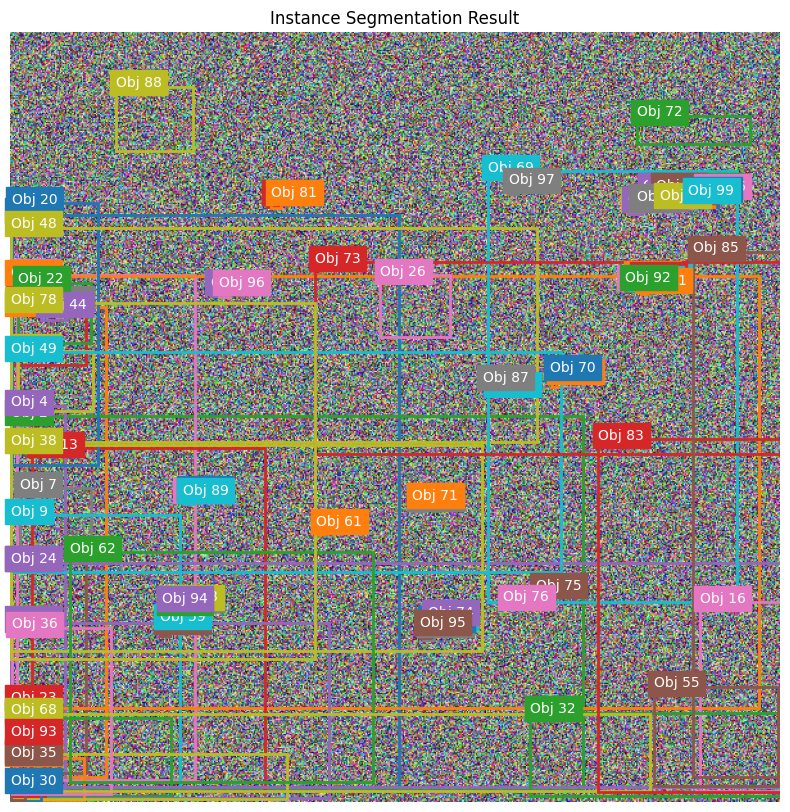

In [4]:
img_to_show = dummy_img[0]
pred_to_show = output[0]
visualize_prediction(img_to_show, pred_to_show)

In [32]:
def load_images_to_numpy(image_paths, target_size=None):
    images = []

    for path in image_paths:
        img = Image.open(path).convert("RGB")

        if target_size is not None:
            img = img.resize(target_size)

        img_np = np.array(img)
        img_np = img_np.transpose(2, 0, 1)

        images.append(img_np)

    batch = np.stack(images, axis=0)
    return batch


real_img = torch.from_numpy(
    load_images_to_numpy(
        [f"./data/WHU-Building-Dataset/train/{n}.TIF" for n in range(10000, 10002)]
    )
).float() / 255

real_targets = [
    {
        'boxes': torch.tensor([[50, 50, 100, 100]], dtype=torch.float32),
        'labels': torch.tensor([1], dtype=torch.int64),
        'masks': torch.randint(0, 2, (1, 1024, 1024), dtype=torch.uint8)
    },
    {
        'boxes': torch.tensor([[150, 150, 200, 200]], dtype=torch.float32),
        'labels': torch.tensor([1], dtype=torch.int64),
        'masks': torch.randint(0, 2, (1, 1024, 1024), dtype=torch.uint8)
    }
]

In [33]:
# Test Forward Pass (Training)
model.train()
loss = model(real_img, real_targets)
print(f"Training Loss: {loss.item()}")

# Test Forward Pass (Inference)
model.eval()
with torch.no_grad():
    output = model(real_img)
    print("Inference Output Boxes:", output[0]['boxes'])
    print("Inference Output Masks Shape:", output[0]['masks'].shape)

Training Loss: 1.827289342880249
Inference Output Boxes: tensor([[ 187.5467,  404.5578,  209.0319,  426.1299],
        [ 675.8123,  408.0451,  716.7165,  441.2746],
        [ 679.3703,  422.8496,  701.9482,  446.8261],
        [1002.7427,  516.8990, 1015.8715,  527.7664],
        [ 327.3973,  984.1302,  342.8742,  997.6999],
        [ 963.2259,  556.4306,  981.6831,  580.8260],
        [ 953.9224,  528.9219,  974.2850,  545.3611],
        [ 998.3568,  513.1400, 1012.9933,  527.2434],
        [ 321.0252,  982.1998,  338.3719,  997.0514],
        [ 803.0505,  506.0578,  825.5276,  526.9122],
        [ 998.6380,  518.4889, 1012.1210,  531.0633],
        [1001.5522,  520.5668, 1014.9521,  533.4357],
        [1003.4791,  511.7535, 1016.7197,  524.8065],
        [ 819.7920,  494.4065,  911.4926,  561.7214],
        [ 326.1886,  989.2089,  340.9492, 1002.1217],
        [ 333.7245,  980.2920,  347.3022,  997.4583],
        [ 955.7364,  517.4083,  975.3245,  538.8631],
        [ 961.1516,  524.

C:\Users\maksy\AppData\Local\Temp\ipykernel_29292\4168754373.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


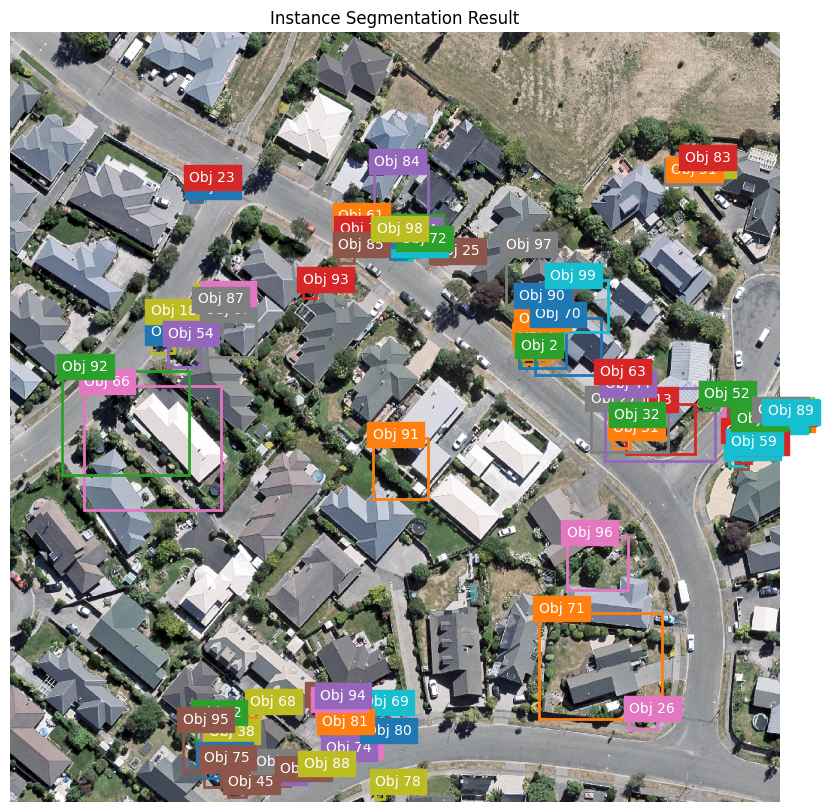

In [34]:
img_to_show = real_img[0]
pred_to_show = output[0]
visualize_prediction(img_to_show, pred_to_show)